<a href="https://colab.research.google.com/github/minashkinvladislav/Frank_Wolfe/blob/main/first_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Квадратичная здадача

In [52]:
from getpass import getpass
!git clone https://github.com/minashkinvladislav/Frank_Wolfe
import numpy as np
from Frank_Wolfe import models
from importlib import reload
reload(models)

<module 'models' from '/content/models.py'>

In [83]:
# задание нашей задачи и ее гиперпараметров
def f(x, args):
    np.random.seed(args['seed'])
    xi = args['sigma'] * np.random.standard_normal(1)
    return 1./2 * x.T @ args['A'] @ x + xi

def nabla_f_true(x, args):
    return args['A'] @ x

args = {}
args['d'] = 10
args['mu'] = 1
args['L'] = 1000
args['func'] = f
args['seed'] = 18
args['A'] = models.generate_A(args['d'], args['mu'], 
                              args['L'], args['seed'])
np.random.seed(args['seed'])
w_0 = np.random.random_sample(args['d'])
w_0 = np.abs(w_0) / np.linalg.norm(w_0, ord = 1)

504


In [55]:
# Надо будет менять для экспериментов
args['sigma'] = 1
args['batch_size'] = 1

In [76]:
# для зеркального спуска будем брать постоянный шаг 1/L
def const_gamma(k, func, nabla_f, x_curr, x_sol, args):
    return 1. / args['L']

Gradient_Descent = models.GradientDescent(f, nabla_f_true, x_0=w_0, max_steps=10**4,
                                          gamma_k=const_gamma, args=args,
                                          criterium='gap', use_mirror=True)
w_sol, _, _ = Gradient_Descent.search()
print("Using true gradient. f(w_sol) = %.5f" % f(w_sol, args))

Using true gradient. f(w_sol) = 26.04074


## Mirror descent

### Two point feedback

In [85]:
reload(models)
args['gamma'] = 10e-10
args['batch_size'] = 50
args['sigma'] = 1
args['seed'] = 18
args['norm'] = 2
args['d'] = 10
print("Approx v1: ", np.round(models.get_grad_tpf(w_0, args), 2))
print("Approx v2:", np.round(models.get_grad_tpf_v2(w_0, args), 5))
print("1-point :", np.round(models.get_grad_opf(w_0, args), 2))
print("True: ", np.round(nabla_f_true(w_0, args), 5))

Approx v1:  [156.09  53.02 155.88 106.54  92.74 170.55  38.74  57.81  93.38 -61.5 ]
Approx v2: [120.1025   45.17648 115.70593  48.99134  77.14094 154.1909   52.35299
  89.728    44.92294 -46.33114]
1-point : [135.91 -27.61  45.94  37.53  84.08 151.12  54.15  92.2  102.77 -38.83]
True:  [120.10249  45.17648 115.70593  48.99133  77.14093 154.1909   52.35298
  89.728    44.92294 -46.33114]


Mirror descent, TPF, norm=1. f(w_sol) = 26.69508             , w_sol in simplex: False


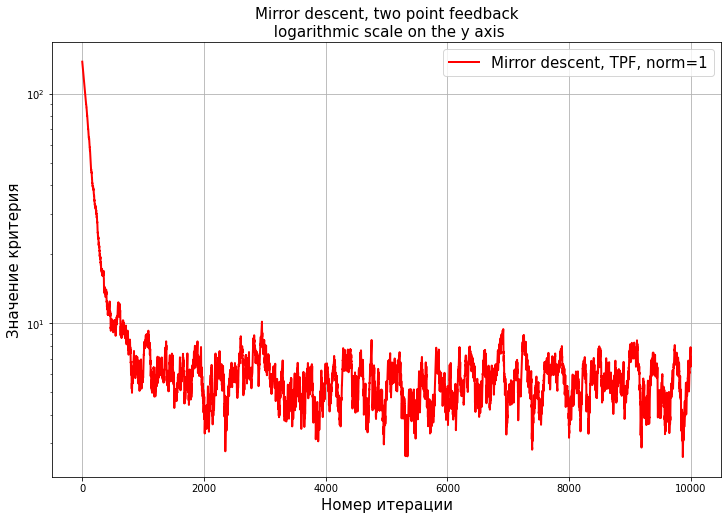

In [79]:
errors_mir_tpf = []
iterations_mir_tpf = []
labels_mir_tpf = []

# errors iterations labels 5 cells
# fw og, mirror desc, proj simplex, prog: MBFW, +dop FW   
for norm in [1]:
      args['norm'] = norm
      mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_tpf, x_0=w_0, 
                                              max_steps=10**4, gamma_k=const_gamma, args=args,
                                              nabla_f_true=nabla_f_true,
                                              criterium='gap', use_fw=True)

      w_sol, errors, _ = mirror_descent.search()
      is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                       and (np.linalg.norm(w_sol, ord=1) == 1))
      iterations = range(1, len(errors)+1)
      errors_mir_tpf.append(errors)
      iterations_mir_tpf.append(iterations)
      labels_mir_tpf.append("Mirror descent, TPF, norm=%i" % norm)
      print("Mirror descent, TPF, norm=%i. f(w_sol) = %.5f \
            , w_sol in simplex: %s" % (norm, f(w_sol, args), is_in_simplex))

title = "Mirror descent, two point feedback"
models.make_err_plot(iterations_mir_tpf, errors_mir_tpf,
                     labels=labels_mir_tpf, title=title, markers=[None]*100)

In [ ]:
print(w_sol)
sum(w_sol)

In [125]:
# OPF, norm = 1
args['gamma'] = 1e-4
args['norm'] = 1
mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_opf, x_0=w_0, 
                                        max_steps=10**4, gamma_k=const_gamma, args=args,
                                        nabla_f_true=nabla_f_true,
                                        criterium='gap', use_mirror=True)

w_sol, errors, _ = mirror_descent.search()
is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                 and (np.linalg.norm(w_sol, ord=1) == 1))
iterations = range(1, len(errors)+1)
errors_mir.append(errors)
iterations_mir.append(iterations)
labels_mir.append("Mirror descent, OPF, norm=1")
print("Mirror descent, OPF, norm=1. f(w_sol) = %.5f \
      , w_sol in simplex: %s" % (f(w_sol, args), is_in_simplex))

# OPF, norm = 2
args['norm'] = 2
mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_opf, x_0=w_0, 
                                        max_steps=10**4, gamma_k=const_gamma, args=args,
                                        nabla_f_true=nabla_f_true,
                                        criterium='gap', use_mirror=True)

w_sol, errors, _ = mirror_descent.search()
is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                 and (np.linalg.norm(w_sol, ord=1) == 1))
iterations = range(1, len(errors)+1)
errors_mir.append(errors)
iterations_mir.append(iterations)
labels_mir.append("Mirror descent, OPF, norm=2")
print("Mirror descent, OPF, norm=2. f(w_sol) = %.5f \
      , w_sol in simplex: %s" % (f(w_sol, args), is_in_simplex))

title = "Mirror descent"
models.make_err_plot(iterations_mir, errors_mir,
                     labels=labels_mir, title=title, markers=[None]*100)
    

KeyboardInterrupt: ignored